In [1]:
from datetime import datetime
import functools
from IPython.display import HTML
import jax
from jax import numpy as jp
import numpy as np
from typing import Any, Dict, Sequence, Tuple, Union
from brax import base
from brax import envs
from brax import math
from brax.base import Base, Motion, Transform
from brax.envs.base import Env, PipelineEnv, State
from brax.mjx.base import State as MjxState
# from brax.training.agents.apg import train as apg
# from brax.training.agents.apg import networks as apg_networks
from brax.io import html, mjcf, model
from etils import epath
from flax import struct
from matplotlib import pyplot as plt
import mediapy as media
from ml_collections import config_dict
import mujoco
from mujoco import mjx
from jax import vmap
import jax.random
from jax import lax

In [2]:
import distutils.util
import os
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

Setting environment variable to use GPU rendering:
env: MUJOCO_GL=egl


In [3]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.8" # 0.9 causes too much lag. 
from datetime import datetime
import functools

# Math
import jax.numpy as jp
import numpy as np
import jax
from jax import config # Analytical gradients work much better with double precision.
config.update("jax_debug_nans", True)
config.update("jax_enable_x64", True)
config.update('jax_default_matmul_precision', jax.lax.Precision.HIGH)
from brax import math

# Sim
import mujoco
import mujoco.mjx as mjx

# Brax
from brax import envs
from brax.base import Motion, Transform
from brax.io import mjcf
from brax.envs.base import PipelineEnv, State
from brax.mjx.pipeline import _reformat_contact
from brax.training.acme import running_statistics
from brax.io import model

# Algorithms
# from brax.training.agents.apg import train as apg
# from brax.training.agents.apg import networks as apg_networks
from brax.training.agents.ppo import train as ppo

# Supporting
from etils import epath
import mediapy as media
import matplotlib.pyplot as plt
from ml_collections import config_dict
from typing import Any, Dict



In [4]:
from utils.SimpleConverter import SimpleConverter
from agent_mimic_env.agent_template import HumanoidTemplate
from agent_mimic_env.agent_eval_template import HumanoidEvalTemplate
from agent_mimic_env.agent_training_template import HumanoidTrainTemplate
from agent_mimic_env.agent_test_apg import HumanoidAPGTest
from utils.util_data import *
from copy import deepcopy

In [5]:
import agent_mimic_env
from agent_mimic_env import register_mimic_env

In [6]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [7]:
import yaml
from box import Box
# Path to your YAML file
yaml_file_path = 'config_params/punch.yaml'
# Load the YAML file
with open(yaml_file_path, 'r') as file:
    args = Box(yaml.safe_load(file))

In [8]:
args

Box({'num_envs': 256, 'num_eval_envs': 32, 'lr': 0.0003, 'max_it': 1000, 'max_grad_norm': 0.4, 'seed': 0, 'system_config': 'humanoid', 'demo_replay_mode': 'threshold', 'threshold': 0.4, 'normalize_observations': True, 'cycle_len': 130, 'ep_len': 65, 'ep_len_eval': 54, 'use_lr_scheduler': True, 'reward_scaling': 0.02, 'rot_weight': 0.5, 'vel_weight': 0.3, 'ang_weight': 0.01, 'deep_mimic_reward_weights': {'w_p': 0.65, 'w_v': 0.1, 'w_e': 0.15, 'w_c': 0.1}, 'deep_mimic_weights_factors': {'w_pose': 2, 'w_angular': 0.1, 'w_efector': 40, 'w_com': 10}, 'model': 'models/final_humanoid.xml', 'ref': 'motions/humanoid3d_punch_duplicated.txt'})

In [9]:
from agent_mimic_env.pds_controllers_agents import feedback_pd_controller, stable_pd_controller_action

In [10]:

env_replay,env_eval, env,env_apg=register_mimic_env(args)

#for the eval here we run the trained policy
jit_reset = jax.jit(env_eval.reset)
jit_step = jax.jit(env_eval.step)

env_eval.set_pd_callback(feedback_pd_controller)

env.set_pd_callback(feedback_pd_controller)
#env_apg.set_pd_callback(stable_pd_controller_action)

this is the model:  models/final_humanoid.xml
this is the model:  models/final_humanoid.xml
this is the model:  models/final_humanoid.xml


In [11]:
env.sys.opt

Option(timestep=0.002, impratio=Array(100., dtype=float64, weak_type=True), tolerance=Array(1.e-08, dtype=float64, weak_type=True), ls_tolerance=Array(0.01, dtype=float64, weak_type=True), gravity=Array([ 0.  ,  0.  , -9.81], dtype=float64), wind=Array([0., 0., 0.], dtype=float64), density=Array(0., dtype=float64, weak_type=True), viscosity=Array(0., dtype=float64, weak_type=True), has_fluid_params=False, integrator=<IntegratorType.EULER: 0>, cone=<ConeType.PYRAMIDAL: 0>, jacobian=<JacobianType.AUTO: 2>, solver=<SolverType.NEWTON: 2>, iterations=1, ls_iterations=4, disableflags=<DisableBit.EULERDAMP: 16384>)

In [12]:
env.sys.actuator.bias_q

Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float64)

In [13]:
episode_len = env_eval.cycle_len
print(env_eval.rollout_lenght)
print(env.err_threshold)
print(env_eval.cycle_len)
print(episode_len)

65
0.4
130
130


In [14]:
print(env_eval.rot_weight)
print(env_eval.vel_weight)
print(env_eval.ang_weight)

0.5
0.3
0.01


In [15]:
env_eval.action_size

28

In [16]:
from brax.training.agents.ppo import train as ppo
from brax.training.agents.ppo import networks as ppo_networks

In [17]:
make_networks_factory = functools.partial(
    ppo_networks.make_ppo_networks,
        policy_hidden_layer_sizes=(512,256),
        value_hidden_layer_sizes=(512,256))
make_networks_factory


functools.partial(<function make_ppo_networks at 0x7f8dcbb3bc40>, policy_hidden_layer_sizes=(512, 256), value_hidden_layer_sizes=(512, 256))

In [18]:
train_fn = functools.partial(
    ppo.train, num_timesteps=30_000_000, num_evals=10, num_eval_envs=32,
    episode_length=episode_len-1, normalize_observations=True, action_repeat=1,
    unroll_length=15, num_minibatches=24, num_updates_per_batch=4,
    discounting=0.95, gae_lambda=0.95,learning_rate=3e-4, clipping_epsilon=0.2,entropy_cost=1e-3, num_envs=256,
    batch_size=256, seed=0,network_factory=make_networks_factory)

/tmp/ipykernel_26375/1945218369.py:30: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim([0, num_steps * 1.25])
/tmp/ipykernel_26375/1945218369.py:39: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim([0, num_steps * 1.25])
/tmp/ipykernel_26375/1945218369.py:48: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim([0, num_steps * 1.25])
/tmp/ipykernel_26375/1945218369.py:57: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim([0, num_steps * 1.25])
/tmp/ipykernel_26375/1945218369.py:66: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim([0, num_steps * 1.25])
/tmp/ipykernel_26375/1945218369.py:75: UserWarning: Att

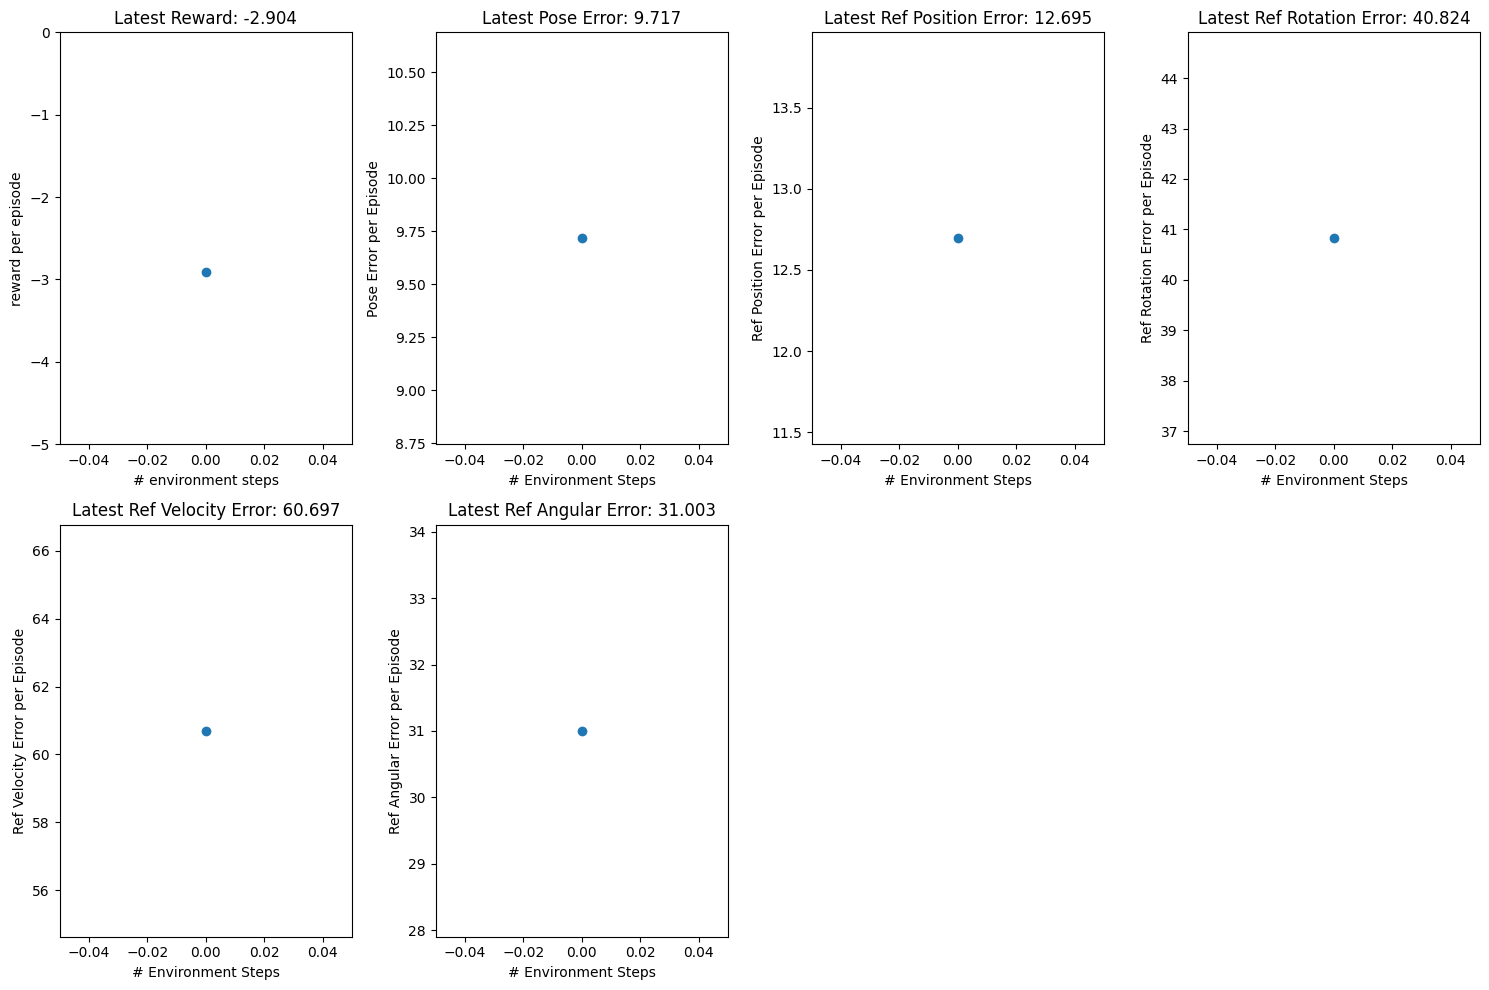

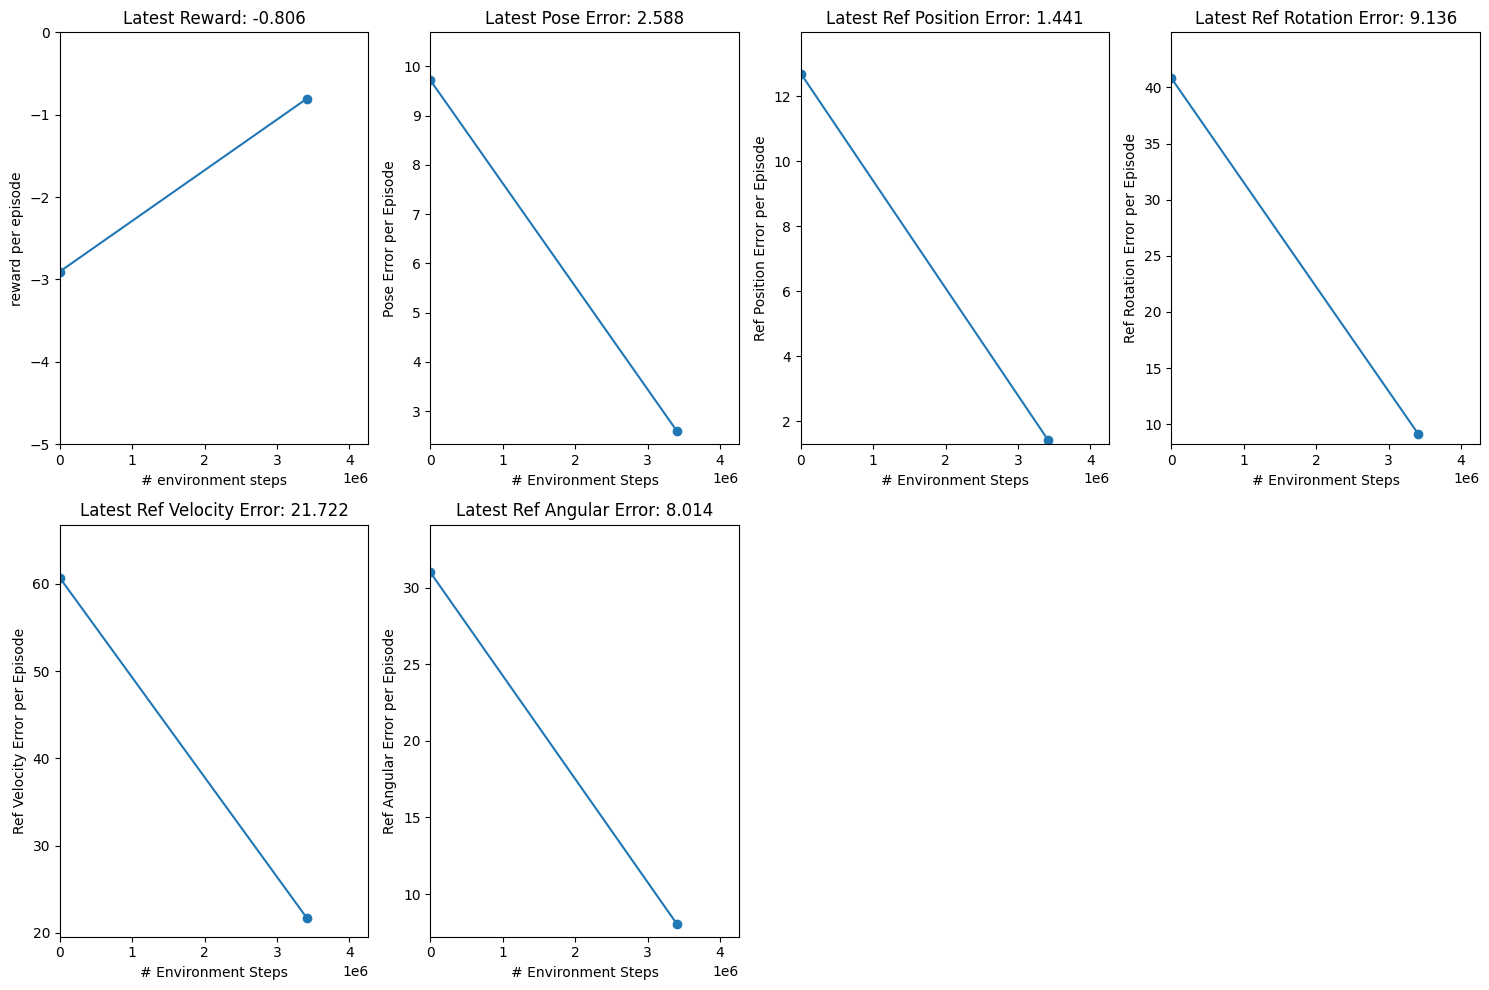

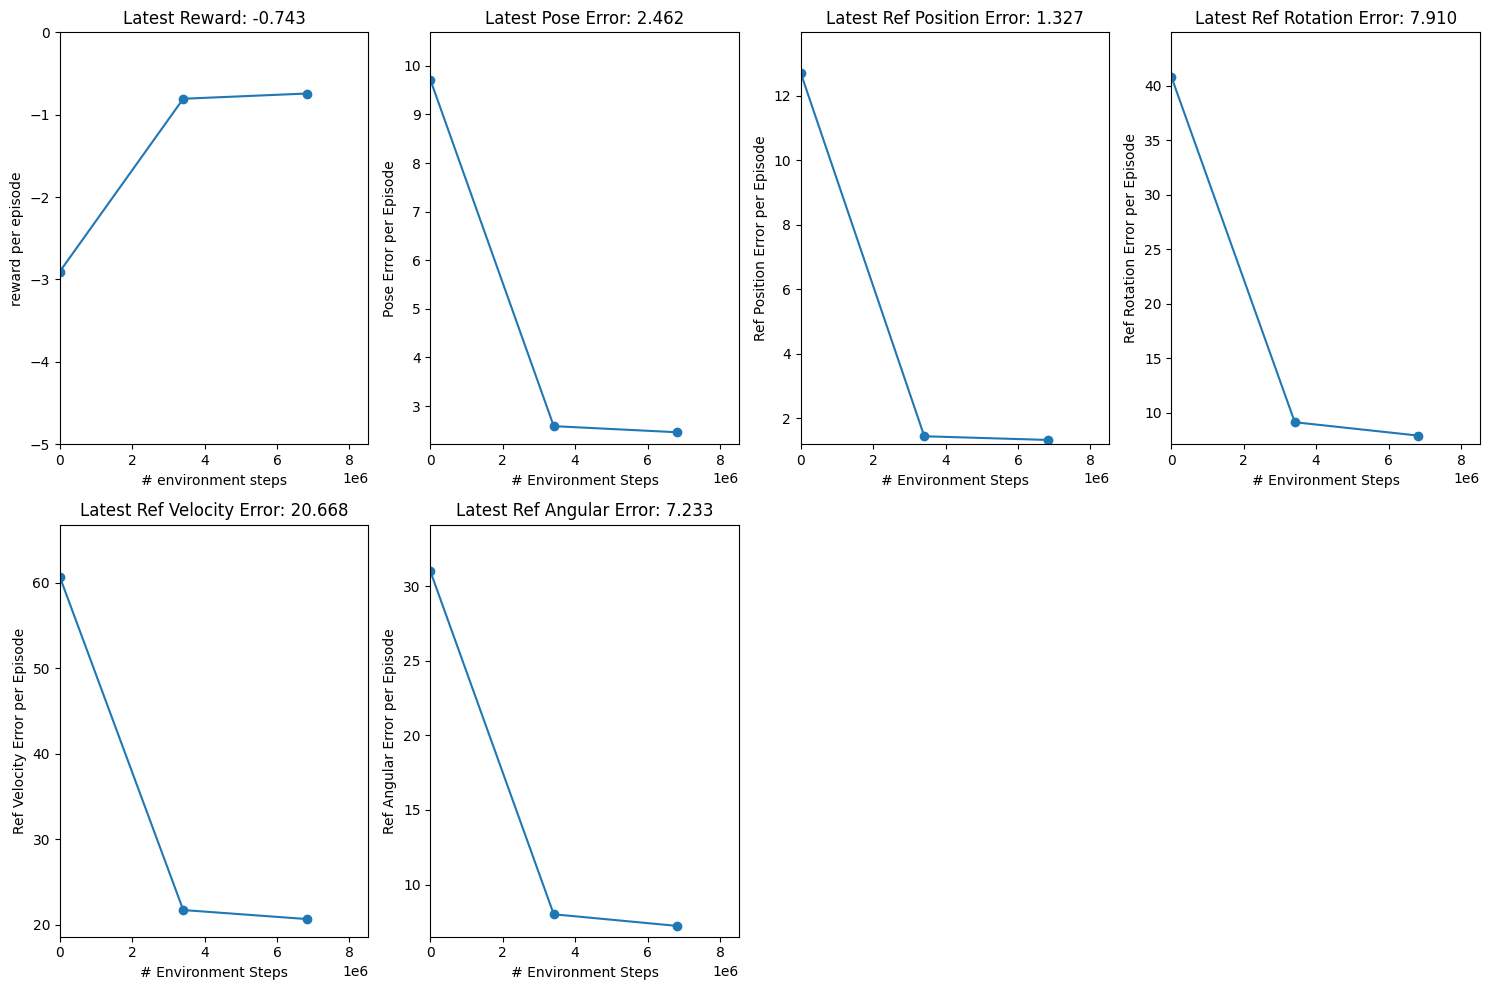

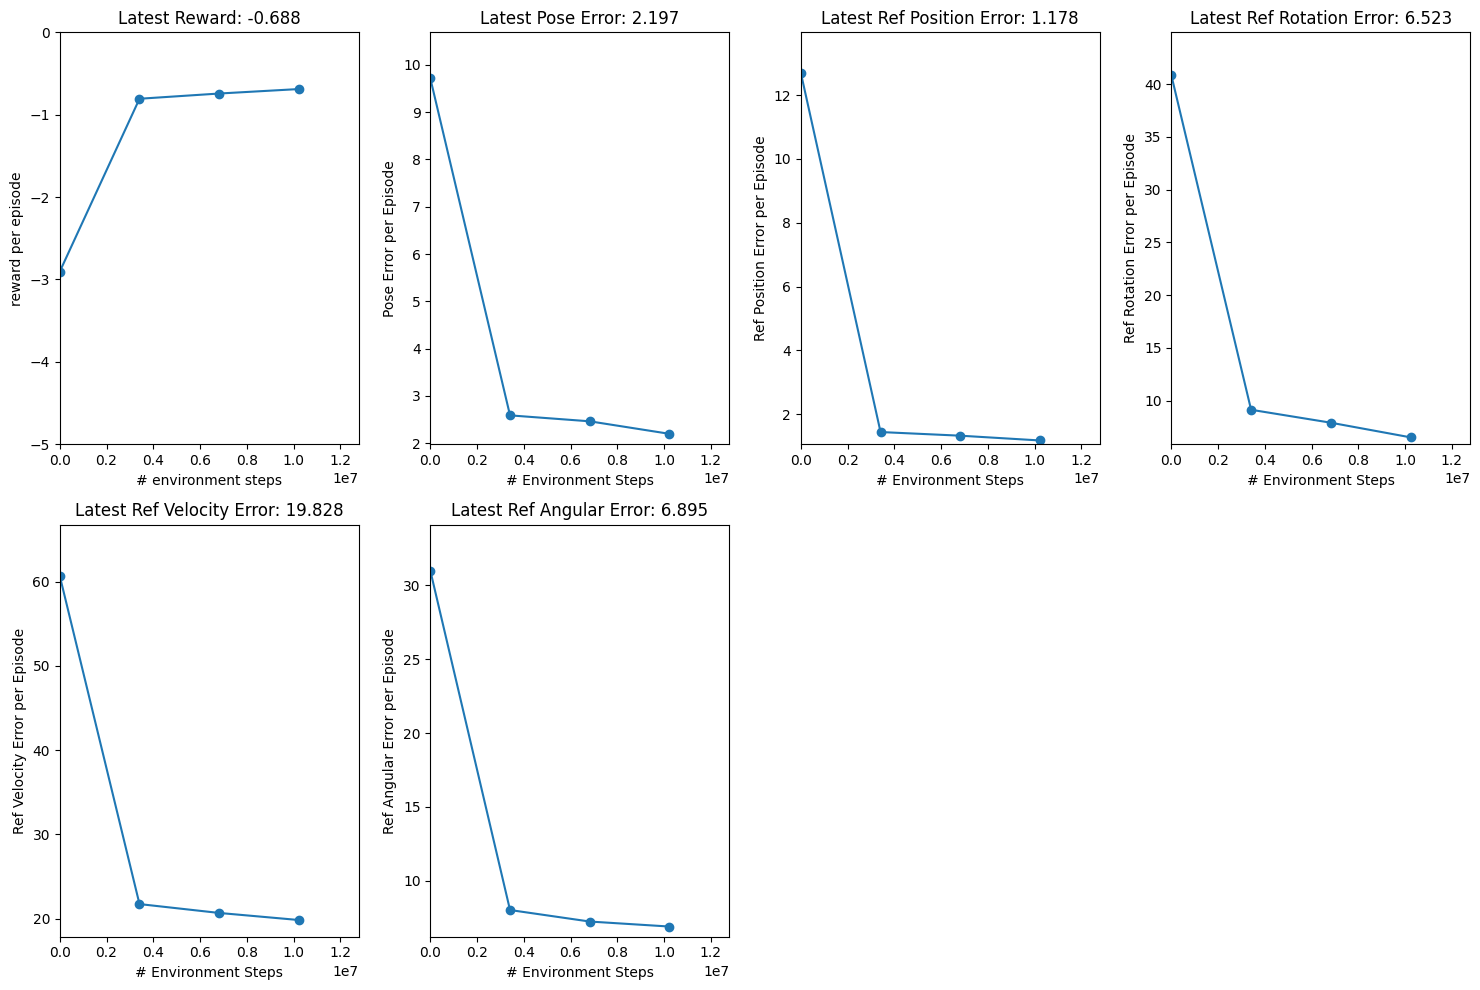

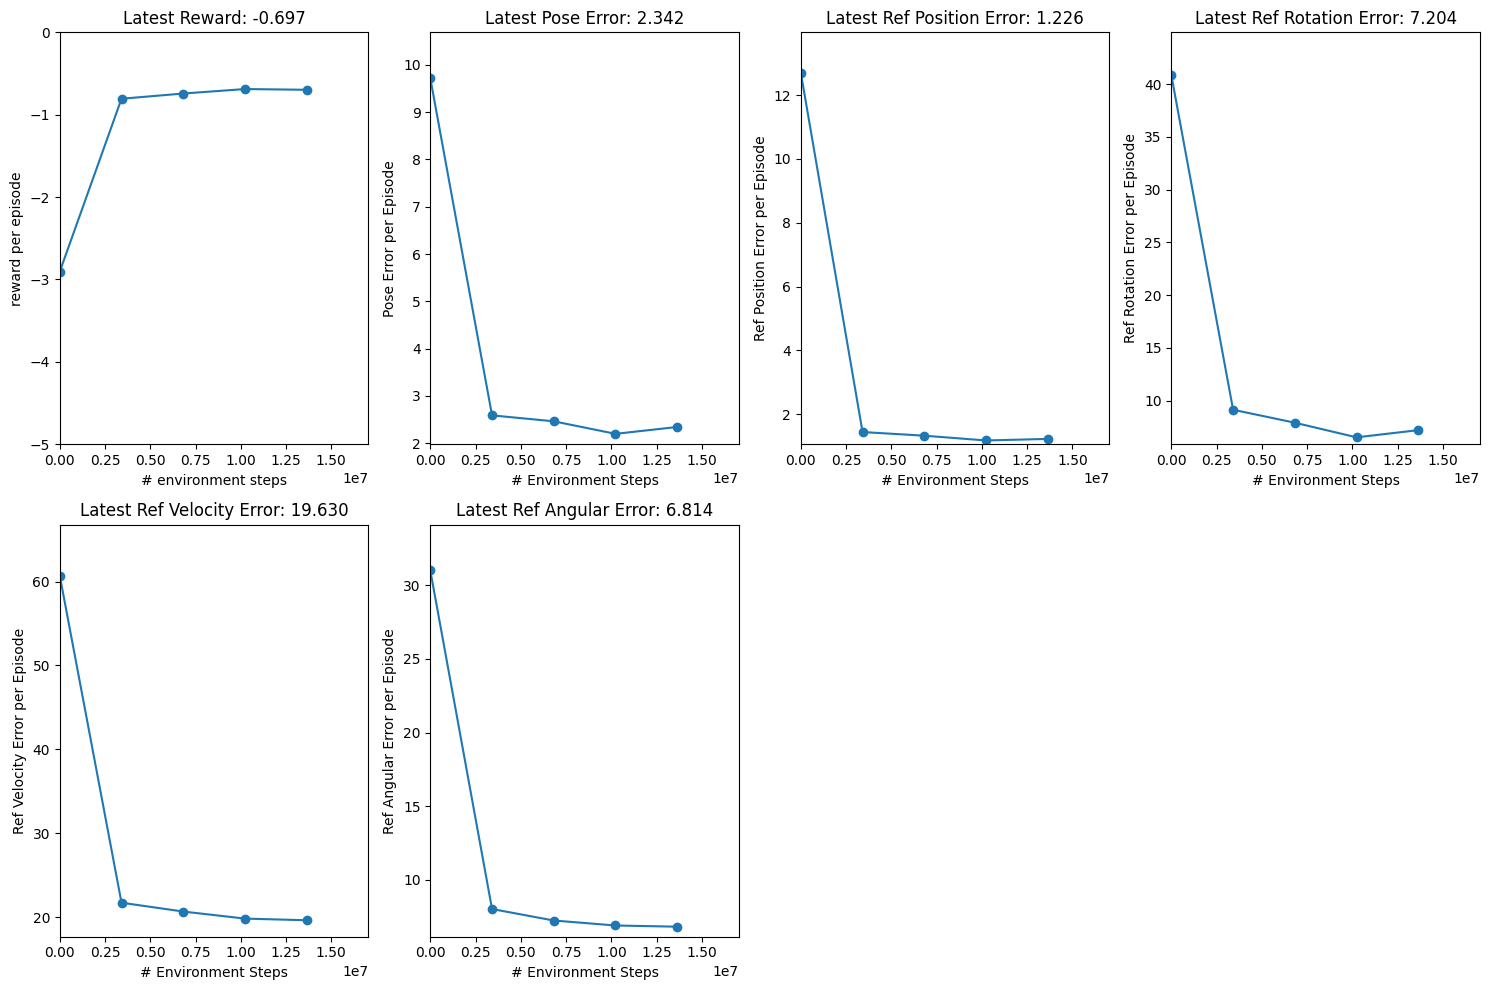

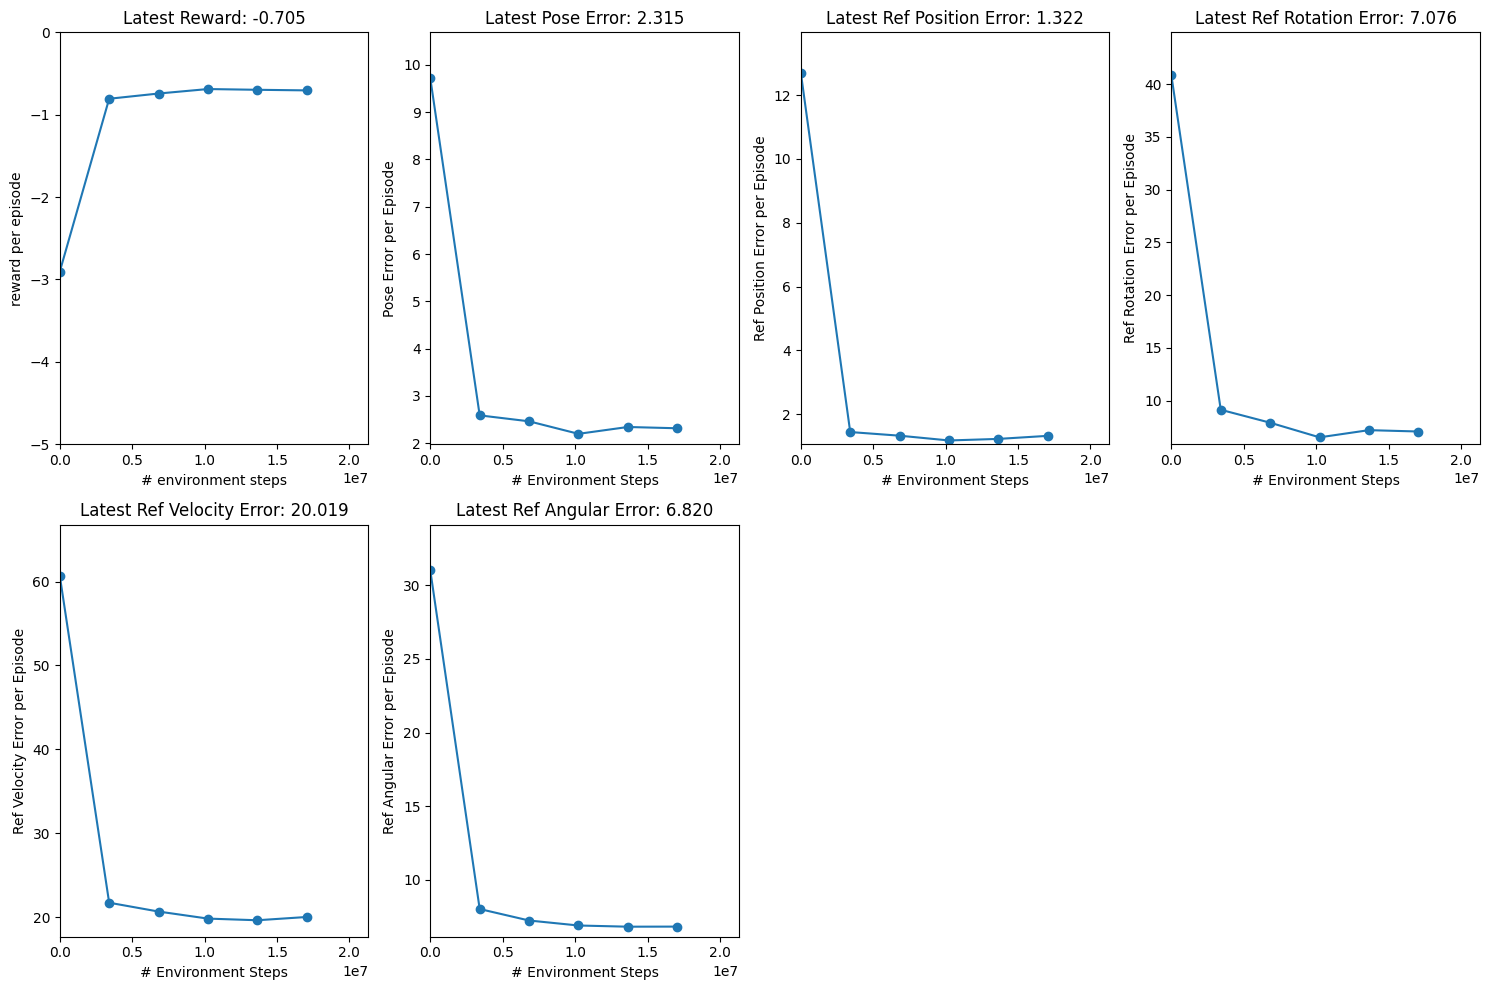

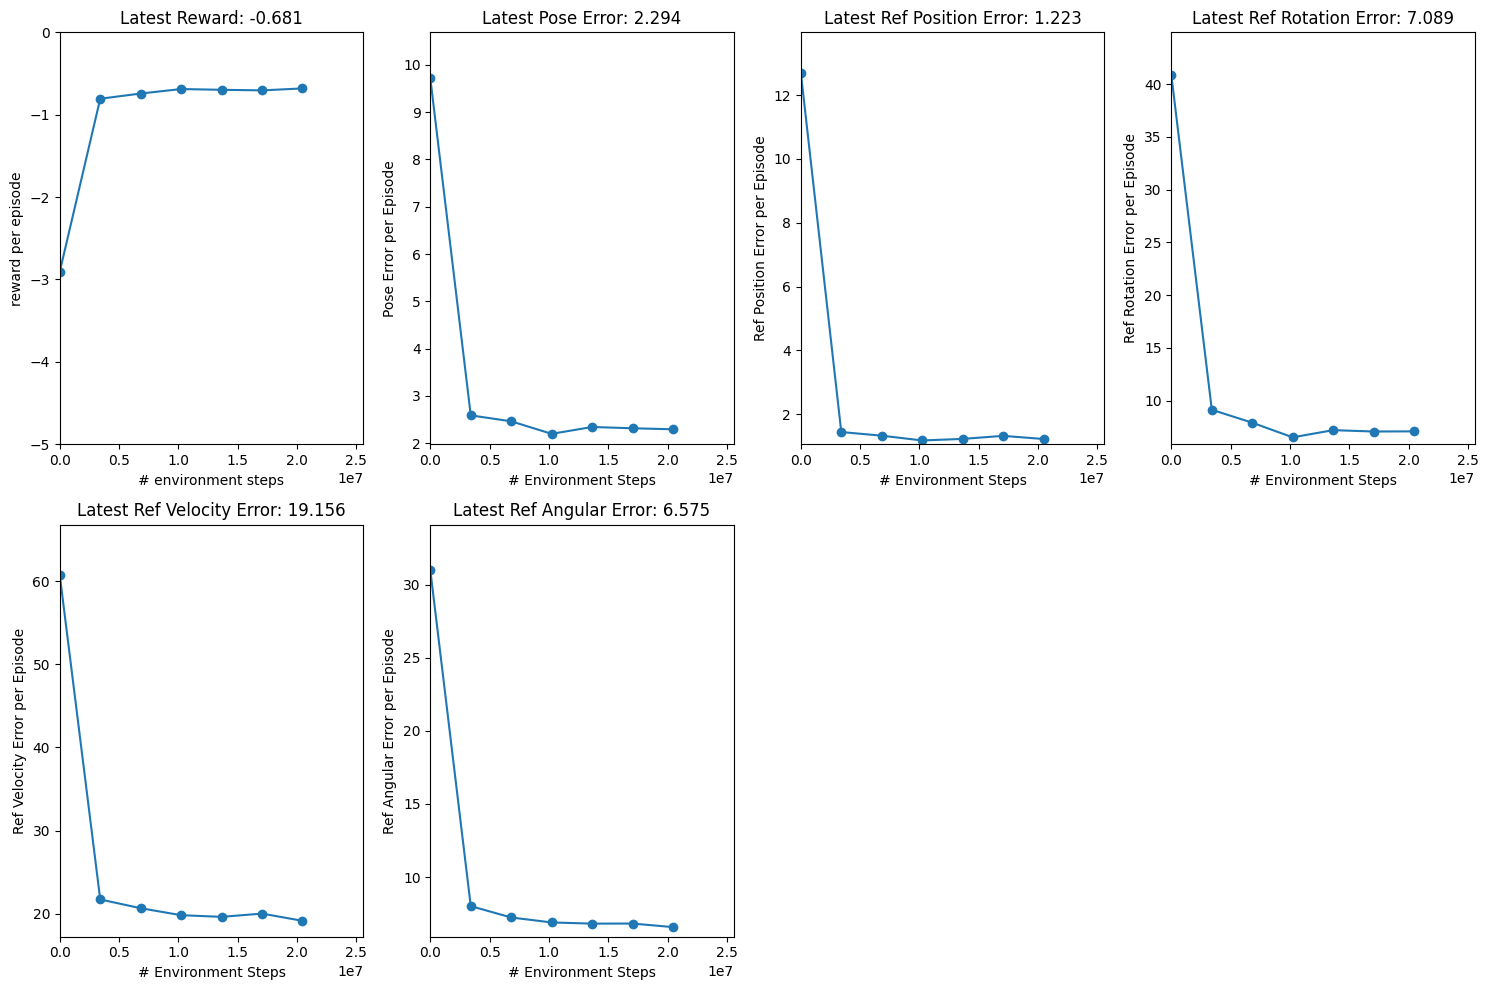

In [ ]:
# Initialize the data lists
x_data = []
y_data = []
ydataerr = []
y_pose_error = []  # to store pose error
y_ref_position = []  # to store reference position error
y_ref_rotation = []  # to store reference rotation error
y_ref_velocity = []  # to store reference velocity error
y_ref_angular = []  # to store reference angular error

times = [datetime.now()]
max_y_rewards, min_y_rewards = 0, -5

# Function to update progress and plot data
def progress(num_steps, metrics):
    times.append(datetime.now())
    x_data.append(num_steps)
    y_data.append(metrics['eval/episode_reward'])
    ydataerr.append(metrics['eval/episode_reward_std'])
    y_pose_error.append(metrics['eval/episode_pose_error'])  # capture pose error
    y_ref_position.append(metrics['eval/episode_reference_position'])  
    y_ref_rotation.append(metrics['eval/episode_reference_rotation'])  
    y_ref_velocity.append(metrics['eval/episode_reference_velocity'])  
    y_ref_angular.append(metrics['eval/episode_reference_angular'])  
 
    plt.figure(figsize=(15, 10))

    # Plot reward per episode
    plt.subplot(2, 4, 1)
    plt.xlim([0, num_steps * 1.25])
    plt.ylim([min_y_rewards, max_y_rewards])
    plt.xlabel('# environment steps')
    plt.ylabel('reward per episode')
    plt.title(f'Latest Reward: {y_data[-1]:.3f}')
    plt.plot(x_data, y_data, '-o')

    # Plot pose error per episode
    plt.subplot(2, 4, 2)
    plt.xlim([0, num_steps * 1.25])
    plt.ylim([min(y_pose_error) * 0.9, max(y_pose_error) * 1.1])
    plt.xlabel('# Environment Steps')
    plt.ylabel('Pose Error per Episode')
    plt.title(f'Latest Pose Error: {y_pose_error[-1]:.3f}')
    plt.plot(x_data, y_pose_error, '-o')

    # Plot reference position error per episode
    plt.subplot(2, 4, 3)
    plt.xlim([0, num_steps * 1.25])
    plt.ylim([min(y_ref_position) * 0.9, max(y_ref_position) * 1.1])
    plt.xlabel('# Environment Steps')
    plt.ylabel('Ref Position Error per Episode')
    plt.title(f'Latest Ref Position Error: {y_ref_position[-1]:.3f}')
    plt.plot(x_data, y_ref_position, '-o')

    # Plot reference rotation error per episode
    plt.subplot(2, 4, 4)
    plt.xlim([0, num_steps * 1.25])
    plt.ylim([min(y_ref_rotation) * 0.9, max(y_ref_rotation) * 1.1])
    plt.xlabel('# Environment Steps')
    plt.ylabel('Ref Rotation Error per Episode')
    plt.title(f'Latest Ref Rotation Error: {y_ref_rotation[-1]:.3f}')
    plt.plot(x_data, y_ref_rotation, '-o')

    # Plot reference velocity error per episode
    plt.subplot(2, 4, 5)
    plt.xlim([0, num_steps * 1.25])
    plt.ylim([min(y_ref_velocity) * 0.9, max(y_ref_velocity) * 1.1])
    plt.xlabel('# Environment Steps')
    plt.ylabel('Ref Velocity Error per Episode')
    plt.title(f'Latest Ref Velocity Error: {y_ref_velocity[-1]:.3f}')
    plt.plot(x_data, y_ref_velocity, '-o')

    # Plot reference angular error per episode
    plt.subplot(2, 4, 6)
    plt.xlim([0, num_steps * 1.25])
    plt.ylim([min(y_ref_angular) * 0.9, max(y_ref_angular) * 1.1])
    plt.xlabel('# Environment Steps')
    plt.ylabel('Ref Angular Error per Episode')
    plt.title(f'Latest Ref Angular Error: {y_ref_angular[-1]:.3f}')
    plt.plot(x_data, y_ref_angular, '-o')

    # Plot min reference tracking error per episode
    plt.tight_layout()
    plt.show()
  

make_inference_fn, params, _= train_fn(environment=env_eval,
                                       progress_fn=progress,
                                       eval_env=env_eval)

print(f'time to jit: {times[1] - times[0]}')
print(f'time to train: {times[-1] - times[1]}')

In [ ]:
import os

# Create a directory if it does not exist
os.makedirs('model_checkpoints', exist_ok=True)

# Save in the subdirectory
model_path = 'model_checkpoints/model_punch_ppo'
model.save_params(model_path, params)

In [ ]:
params = model.load_params(model_path)

inference_fn = make_inference_fn(params)
jit_inference_fn = jax.jit(inference_fn)

In [ ]:
# initialize the state
rng = jax.random.PRNGKey(0)
state = jit_reset(rng)
rollout = [state.pipeline_state]

# grab a trajectory
n_steps = 500
render_every = 2

for i in range(n_steps):
  act_rng, rng = jax.random.split(rng)
  ctrl, _ = jit_inference_fn(state.obs, act_rng)
  state = jit_step(state, ctrl)
  rollout.append(state.pipeline_state)

  if state.done:
    break

In [ ]:
HTML(html.render(env_eval.sys.tree_replace({'opt.timestep': env_eval.dt}), rollout))
